In [1]:
# %matplotlib inline
import glob
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.feature import greycomatrix, greycoprops
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import MDS, Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE
import pandas as pd
from collections import defaultdict
from mpl_toolkits import mplot3d

Text(0.5, 1.0, 'AMA')

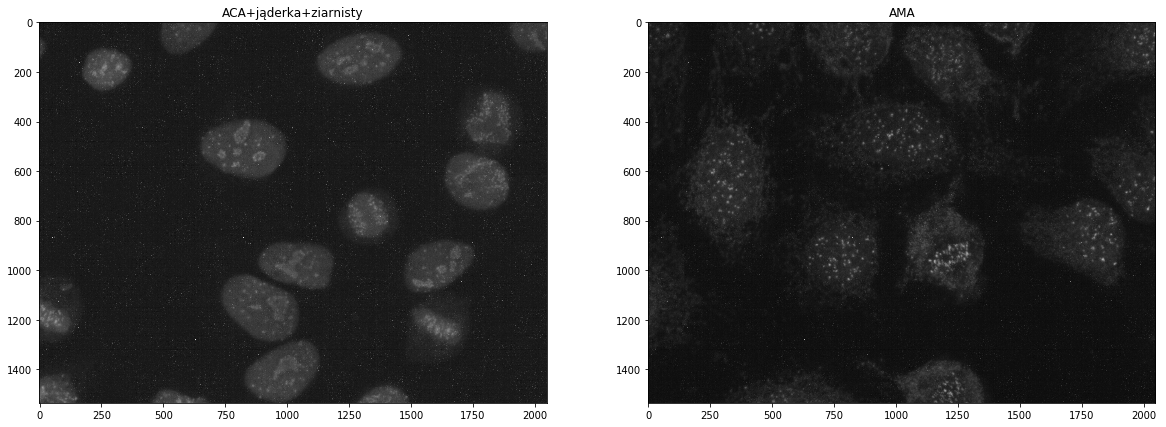

In [2]:
ama = cv.imread('./data/sample/aca+ama4.png')
aca = cv.imread('./data/sample/ACA+jąderka+ziarnisty(HEp2IIF)4.png')

ama_gray = cv.cvtColor(ama, cv.COLOR_BGR2GRAY)
aca_gray = cv.cvtColor(aca, cv.COLOR_BGR2GRAY)

f, axes = plt.subplots(1, 2)
f.set_size_inches(20, 10)

axes[0].imshow(aca_gray, cmap='gray')
axes[0].set_title('ACA+jąderka+ziarnisty')

axes[1].imshow(ama_gray, cmap='gray')
axes[1].set_title('AMA')

## Preprocessing (resizing and denoising)

In [3]:
def preprocess(img, size):
    img = img.copy()
    
    #resizing and denoising
    img = cv.resize(img, dsize=size, interpolation=cv.INTER_CUBIC)
    img = cv.fastNlMeansDenoising(img, h=2)
    
    # normalization
    min_ = np.amin(img)
    max_ = np.amax(img)
    norm = (img - min_) * (255 / (max_ - min_))
    return norm.astype(np.uint)

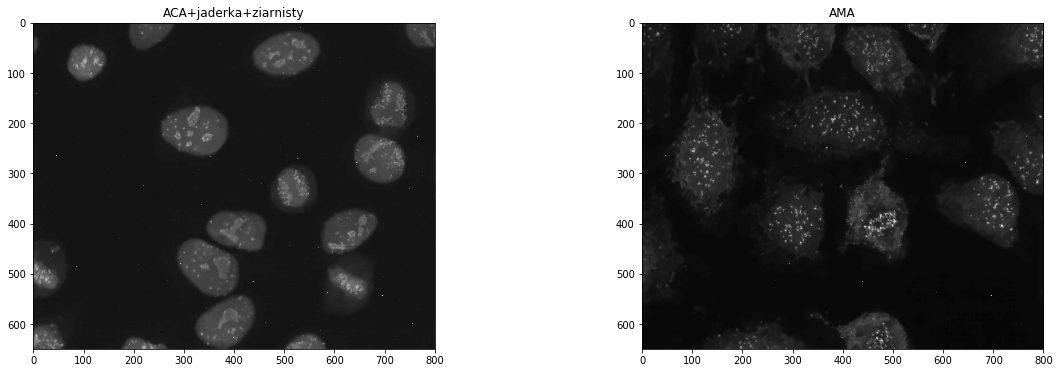

In [4]:
ref_aca = preprocess(aca_gray, (800, 650))
ref_ama = preprocess(ama_gray, (800, 650))

f, a = plt.subplots(1, 2)
f.set_size_inches(20, 6)

a[0].imshow(ref_aca, cmap='gray')
a[0].set_title('ACA+jaderka+ziarnisty')

a[1].imshow(ref_ama, cmap='gray')
a[1].set_title('AMA')

plt.show()

## K means colors compression

In [5]:
def cluster_colors(img, colors=8, sort_centroids=True, only_predictions=False):
    flat = img.reshape(-1, 1)
    model = KMeans(n_clusters=colors).fit(flat)
    
    clusters = model.predict(flat)
    predictions = clusters.reshape(img.shape)
    
    if sort_centroids:
        ref = model.cluster_centers_.reshape(-1)
        clusters_order = sorted(list(range(model.n_clusters)), key=(lambda x: ref[x]))
        order = np.zeros(model.n_clusters, dtype=np.uint8)
        
        for i, c in enumerate(clusters_order):
            order[c] = i
            
        predictions = np.take(order, predictions)
        
    if only_predictions:
        return predictions, model
    
    result = np.take(model.cluster_centers_, predictions)
    
    return result, model

def transform_colors(img, model, sort_centroids=True, only_predictions=False):
    flat = img.reshape(-1, 1)
    predictions = model.predict(flat).reshape(img.shape)
    
    if sort_centroids:
        ref = model.cluster_centers_.reshape(-1)
        clusters_order = sorted(list(range(model.n_clusters)), key=(lambda x: ref[x]))
        order = np.zeros(model.n_clusters, dtype=np.uint8)
        
        for i, c in enumerate(clusters_order):
            order[c] = i
            
        predictions = np.take(order, predictions)
        
    if only_predictions:
        return predictions
    
    return np.take(model.cluster_centers_, predictions)

In [6]:
comp_aca, model_aca = cluster_colors(ref_aca, colors=8, only_predictions=True)

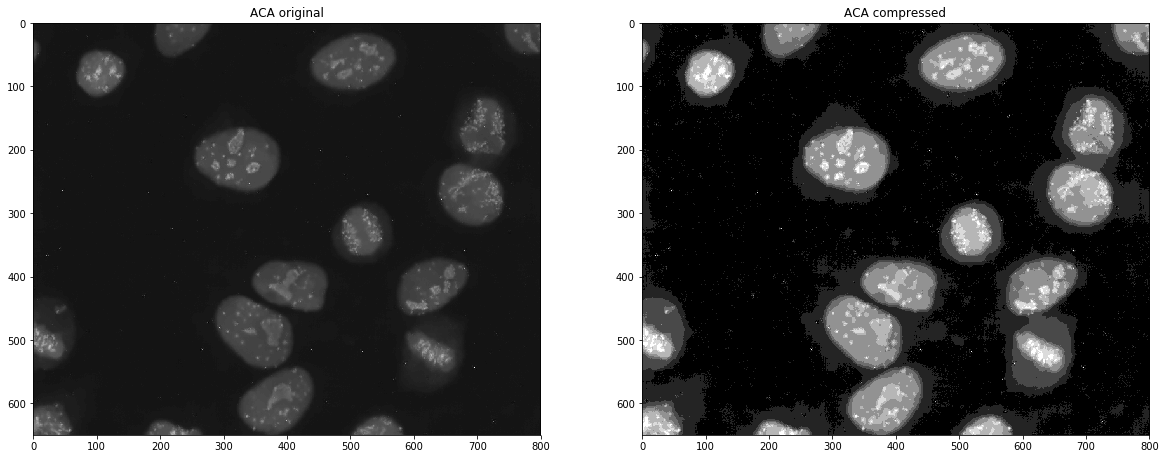

In [7]:
f, a = plt.subplots(1, 2)
f.set_size_inches(20, 20)
a = a.reshape(-1,)

a[0].imshow(ref_aca, cmap='gray')
a[0].set_title('ACA original')

a[1].imshow(comp_aca, cmap='gray')
a[1].set_title('ACA compressed')

plt.show()

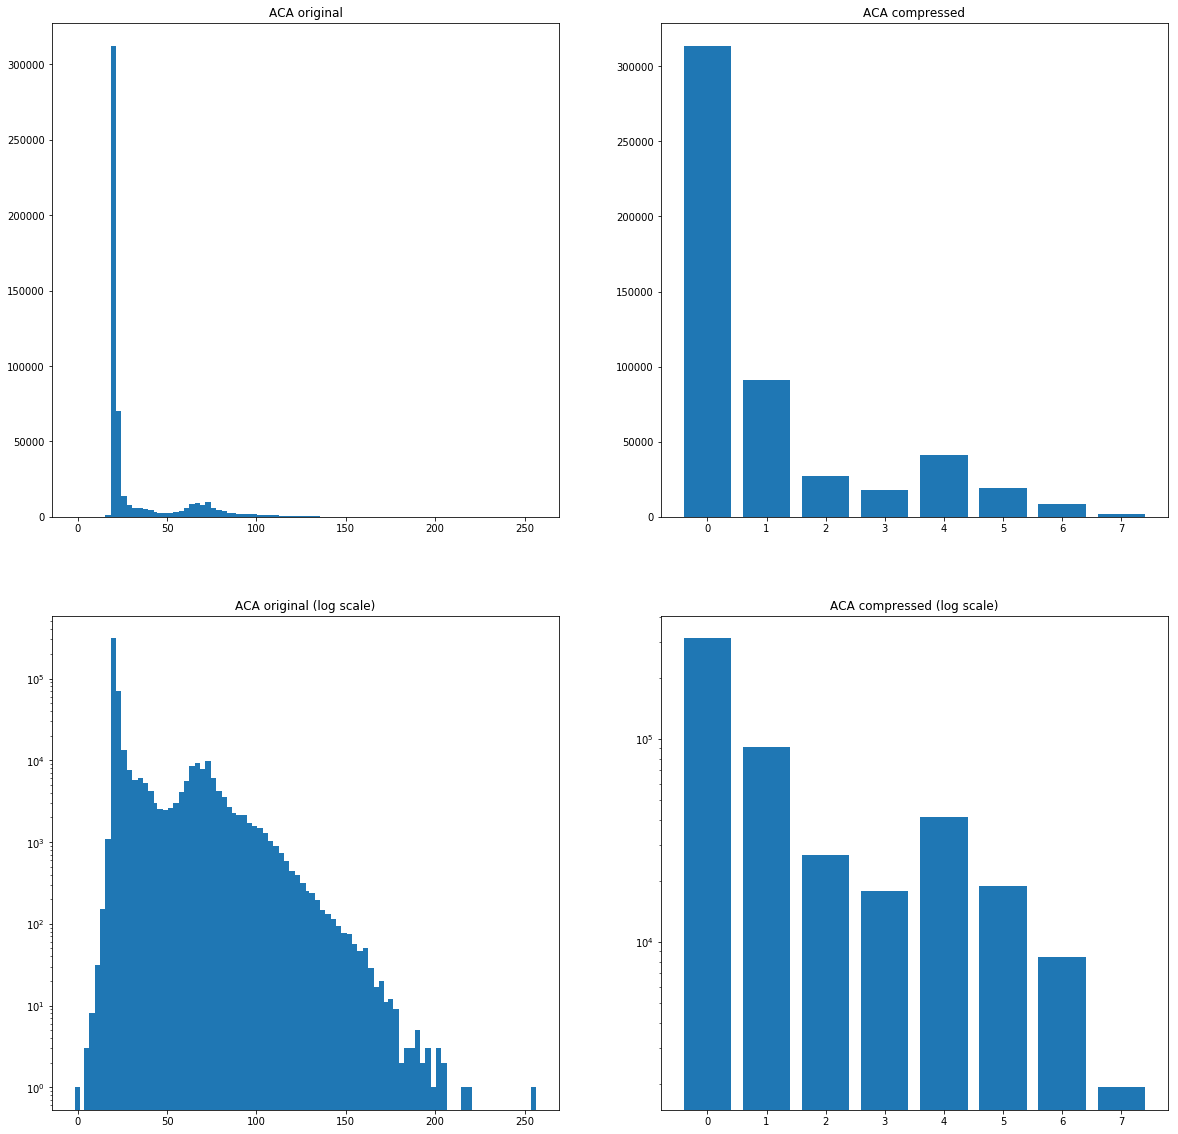

In [8]:
f, a = plt.subplots(2, 2)
f.set_size_inches(20, 20)
a = a.reshape(-1,)

bins, _ = np.histogram(ref_aca, bins=256, range=(0, 255))
a[0].bar(x=range(256), height=bins, width=3)
a[0].set_title('ACA original')

bins, _ = np.histogram(comp_aca, bins=8, range=(0, 7))
a[1].bar(x=range(8), height=bins)
a[1].set_title('ACA compressed')

bins, _ = np.histogram(ref_aca, bins=256, range=(0, 255))
a[2].bar(x=range(256), height=bins, width=3, log=True)
a[2].set_title('ACA original (log scale)')

bins, _ = np.histogram(comp_aca, bins=8, range=(0, 7))
a[3].bar(x=range(8), height=bins, log=True)
a[3].set_title('ACA compressed (log scale)')

plt.show()

In [9]:
comp_ama, model_ama = cluster_colors(ref_ama, colors=8, only_predictions=True)

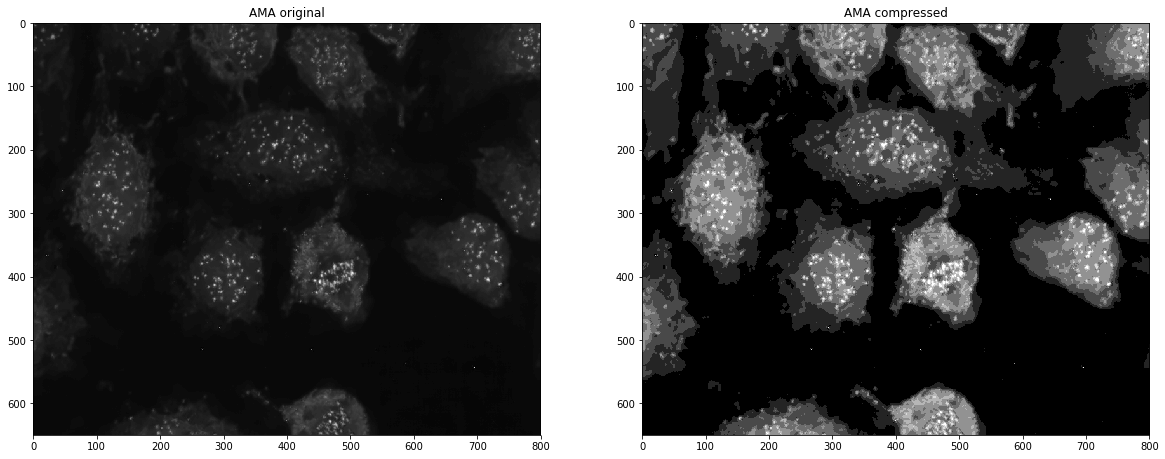

In [10]:
f, a = plt.subplots(1, 2)
f.set_size_inches(20, 20)
a = a.reshape(-1,)

a[0].imshow(ref_ama, cmap='gray')
a[0].set_title('AMA original')

a[1].imshow(comp_ama, cmap='gray')
a[1].set_title('AMA compressed')

plt.show()

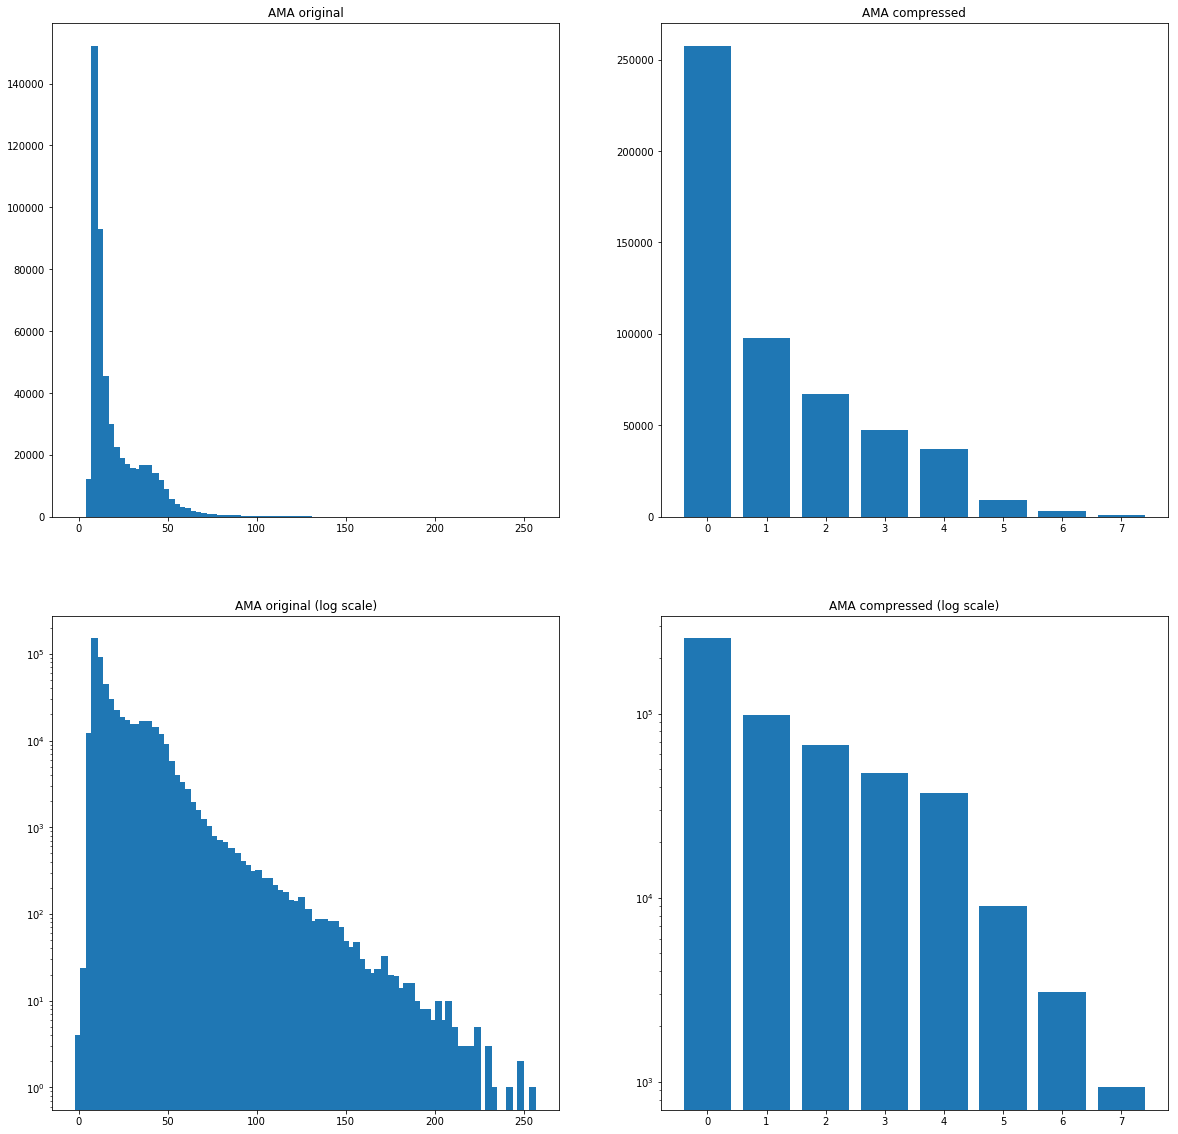

In [11]:
f, a = plt.subplots(2, 2)
f.set_size_inches(20, 20)
a = a.reshape(-1,)

bins, _ = np.histogram(ref_ama, bins=256, range=(0, 255))
a[0].bar(x=range(256), height=bins, width=4)
a[0].set_title('AMA original')

bins, _ = np.histogram(comp_ama, bins=8, range=(0, 7))
a[1].bar(x=range(8), height=bins)
a[1].set_title('AMA compressed')

bins, _ = np.histogram(ref_ama, bins=256, range=(0, 255))
a[2].bar(x=range(256), height=bins, width=4, log=True)
a[2].set_title('AMA original (log scale)')

bins, _ = np.histogram(comp_ama, bins=8, range=(0, 7))
a[3].bar(x=range(8), height=bins, log=True)
a[3].set_title('AMA compressed (log scale)')

plt.show()

## Threshold based foreground separation

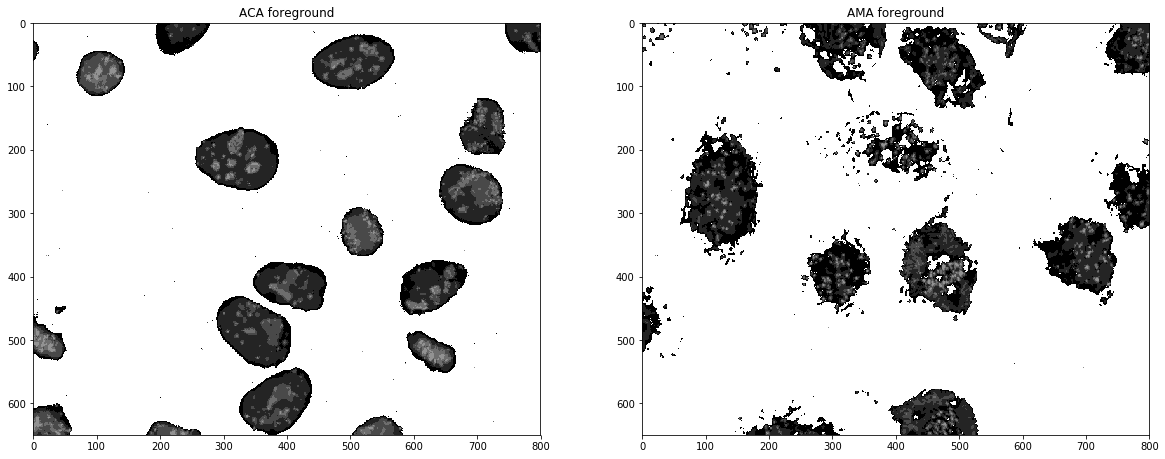

In [12]:
threshold = 3

f, a = plt.subplots(1, 2)
f.set_size_inches(20, 20)
a = a.reshape(-1,)

foreground_aca = comp_aca.copy()
foreground_aca[foreground_aca < threshold] = 10
a[0].imshow(foreground_aca, cmap='gray')
a[0].set_title('ACA foreground')

foreground_ama = comp_ama.copy()
foreground_ama[foreground_ama < threshold] = 10
a[1].imshow(foreground_ama, cmap='gray')
a[1].set_title('AMA foreground')

plt.show()

## Cells extraction with dbscan

In [13]:
def find_cells(img, threshold, eps=20, min_samples=0.95):
    
    if min_samples <= 1:
        min_samples = np.pi * eps**2 * min_samples
        
    features = np.argwhere(img >= threshold)
    model = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
    return model, features

In [14]:
%%time
eps = 20

aca_dbscan, aca_feat = find_cells(comp_aca, threshold, eps=eps)
ama_dbscan, ama_feat = find_cells(comp_ama, threshold, eps=eps)

CPU times: user 6.14 s, sys: 236 ms, total: 6.38 s
Wall time: 6.39 s


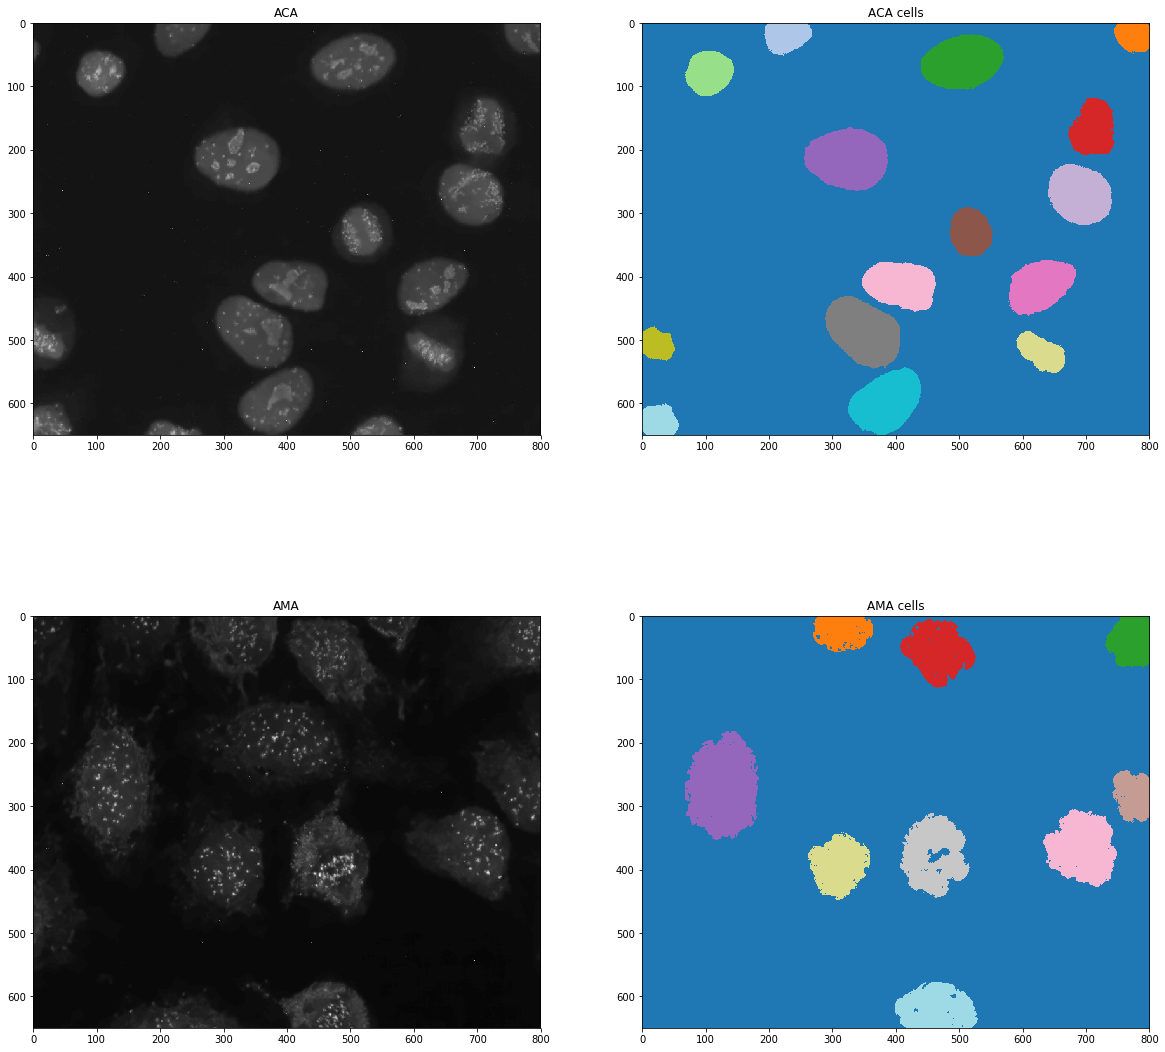

In [15]:
f, a = plt.subplots(2, 2)
f.set_size_inches(20, 20)
a = a.reshape(-1,)

a[0].imshow(ref_aca, cmap='gray')
a[0].set_title('ACA')

aca_cells = np.full(comp_aca.shape, fill_value=-1)
aca_cells[aca_feat[:, 0], aca_feat[:, 1]] = aca_dbscan.labels_
aca_cells = aca_cells + 1
a[1].imshow(aca_cells, cmap='tab20')
a[1].set_title('ACA cells')

a[2].imshow(ref_ama, cmap='gray')
a[2].set_title('AMA')

ama_cells = np.full(comp_ama.shape, fill_value=-1)
ama_cells[ama_feat[:, 0], ama_feat[:, 1]] = ama_dbscan.labels_
ama_cells = ama_cells + 1
a[3].imshow(ama_cells, cmap='tab20')
a[3].set_title('AMA cells')

plt.show()

## Cells to color histograms

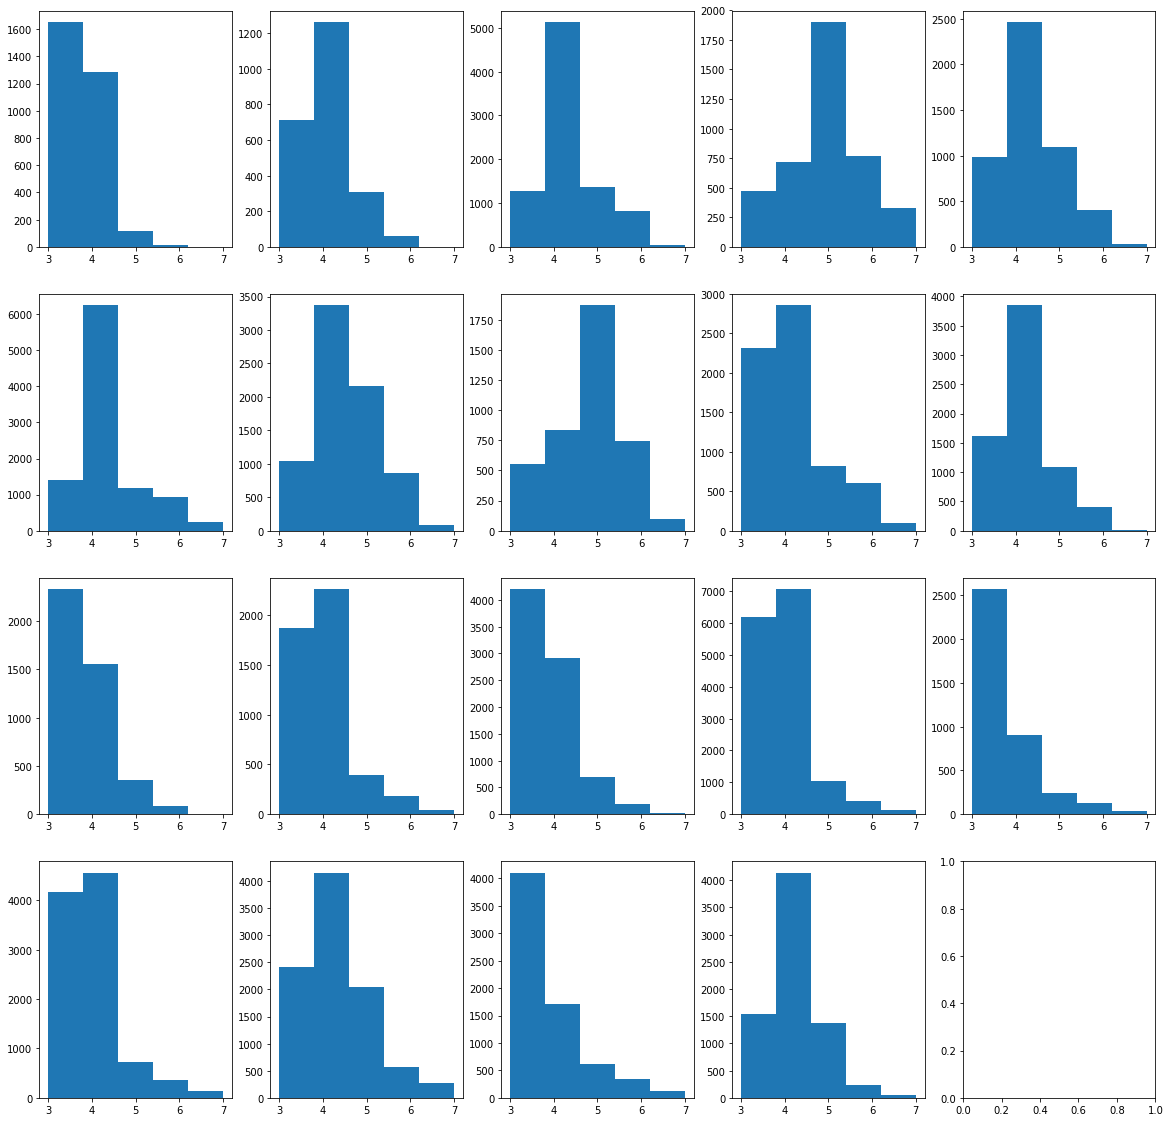

In [16]:
aca_clusters = np.amax(aca_dbscan.labels_) + 1
ama_clusters = np.amax(ama_dbscan.labels_) + 1

f, a = plt.subplots(4, 5)
a = a.reshape(-1)
f.set_size_inches(20, 20)

for c in range(min(aca_clusters, 10)):
    points = aca_feat[aca_dbscan.labels_ == c]
    pixels = comp_aca[points[:, 0], points[:, 1]]
    a[c].hist(pixels.reshape(-1), bins=5, range=(3, 7), log=False)
    
for c in range(min(ama_clusters, 10)):
    points = ama_feat[ama_dbscan.labels_ == c]
    pixels = comp_ama[points[:, 0], points[:, 1]]
    a[min(aca_clusters, 10) + c].hist(pixels.reshape(-1), bins=5, range=(3, 7), log=False)
    
plt.show()

In [17]:
aca_hists = []
ama_hists = []

for c in range(aca_clusters):
    points = aca_feat[aca_dbscan.labels_ == c]
    pixels = comp_aca[points[:, 0], points[:, 1]]
    bins, _ = np.histogram(pixels, bins=(8 - threshold), range=(threshold, 7))
    aca_hists.append(bins)
    
for c in range(ama_clusters):
    points = ama_feat[ama_dbscan.labels_ == c]
    pixels = comp_ama[points[:, 0], points[:, 1]]
    bins, _ = np.histogram(pixels, bins=(8 - threshold), range=(threshold, 7))
    ama_hists.append(bins)
    
cells_x = np.concatenate([aca_hists, ama_hists])
labels = aca_clusters * [0] + ama_clusters * [1]
labels = np.array(labels).reshape(-1, 1)

cells_df = pd.DataFrame(np.concatenate([cells_x, labels], axis=1))

In [18]:
cells_df

,0,1,2,3,4,5
0,1653,1286,116,15,1,0
1,712,1263,307,62,2,0
2,1277,5137,1368,812,39,0
3,473,715,1902,768,332,0
4,985,2467,1090,400,36,0
5,1416,6247,1182,937,249,0
6,1034,3366,2156,864,87,0
7,550,837,1872,748,94,0
8,2308,2852,812,599,94,0
9,1622,3846,1081,396,16,0


## Encapsulating the whole process in a single procedure

In [22]:
def img_to_cells(img_path, size=(800, 650), compression_colors=8, threshold=3, normalization='none'):
    
    # reads image file
    img = cv.imread(img_path)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # resizes and denoises
    ref = preprocess(img_gray, size)
    
    # compresses colors
    compressed, _ = cluster_colors(ref, colors=compression_colors, only_predictions=True)
    
    # extracts cell areas
    dbscan, features = find_cells(compressed, threshold)
    
    cells_number = np.amax(dbscan.labels_) + 1
    hists = []

    for c in range(cells_number):
        points = features[dbscan.labels_ == c]
        pixels = compressed[points[:, 0], points[:, 1]]
        bins, _ = np.histogram(
            pixels,
            bins=(compression_colors - threshold),
            range=(threshold, compression_colors - 1)
        )
        
        if normalization == 'scale_to_1':
            min_val = np.amin(bins)
            max_val = np.amax(bins)
            bins = (bins - min_val) / (max_val - min_val)
            
        if normalization == 'sum_to_1':
            bins = bins / np.sum(bins)
            
        hists.append(bins)
        
    return np.array(hists)

In [23]:
data_dir = './data/sample/'

aca_imgs = [data_dir + file for file in os.listdir(data_dir) if 'ziarnisty' in file]
ama_imgs = [data_dir + file for file in os.listdir(data_dir) if 'ama' in file]
aca_imgs, ama_imgs

(['./data/sample/ACA+jąderka+ziarnisty(HEp2IIF)1.png',
  './data/sample/ACA+jąderka+ziarnisty(HEp2IIF)4.png',
  './data/sample/ACA+jąderka+ziarnisty(HEp2IIF)2.png',
  './data/sample/ACA+jąderka+ziarnisty(HEp2IIF)5.png',
  './data/sample/ACA+jąderka+ziarnisty(HEp2IIF)3.png',
  './data/sample/ACA+jąderka+ziarnisty(HEp2IIF)6.png'],
 ['./data/sample/aca+ama.png',
  './data/sample/aca+ama1.png',
  './data/sample/aca+ama3.png',
  './data/sample/aca+ama4.png'])

In [24]:
%%time
norm = 'sum_to_1'
aca_cells = [img_to_cells(img, normalization=norm) for img in aca_imgs]
aca_cells = np.concatenate(aca_cells)

ama_cells = [img_to_cells(img, normalization=norm) for img in ama_imgs]
ama_cells = np.concatenate(ama_cells)

CPU times: user 2min 5s, sys: 58.8 s, total: 3min 4s
Wall time: 1min 15s


In [25]:
all_cells = np.concatenate([aca_cells, ama_cells])

aca_count = aca_cells.shape[0]
ama_count = ama_cells.shape[0]
labels = np.array([0] * aca_count + [1] * ama_count)

print('aca count:', aca_count)
print('ama count:', ama_count)

aca count: 91
ama count: 41


## Results visualization

In [26]:
def perform_pca(data, number_of_components, scale=False):
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    pca = PCA(n_components=number_of_components)
    components = pca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    
    return components_dataframe, pca

def perform_kernel_pca(data, number_of_components, scale=False):
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    kpca = KernelPCA(kernel="rbf", n_components=number_of_components)
    components = kpca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    
    return components_dataframe, kpca

def perform_mds(data, number_of_components, scale=False):
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    mds = MDS(n_components=number_of_components)
    components = mds.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe, mds
    
def perform_isomap(data, number_of_components, number_of_neighbors, scale=False):
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    iso = Isomap(n_neighbors=number_of_neighbors,n_components=number_of_components)
    components = iso.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe, iso

def perform_lle(data, number_of_components, number_of_neighbors, scale=False):
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    lle = LLE(n_neighbors=number_of_neighbors,n_components=number_of_components)
    components = lle.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe, lle

def plot_components(components, dims, plot_kwargs={}):

    if dims == 2:
        plt.scatter(components[0], components[1], **plot_kwargs)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")  
        plt.show()
    
    elif dims == 3:
        ax = plt.axes(projection='3d')
        ax.scatter3D(components[0], components[1], components[2], **plot_kwargs);
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        plt.show()

<IPython.core.display.Javascript object>


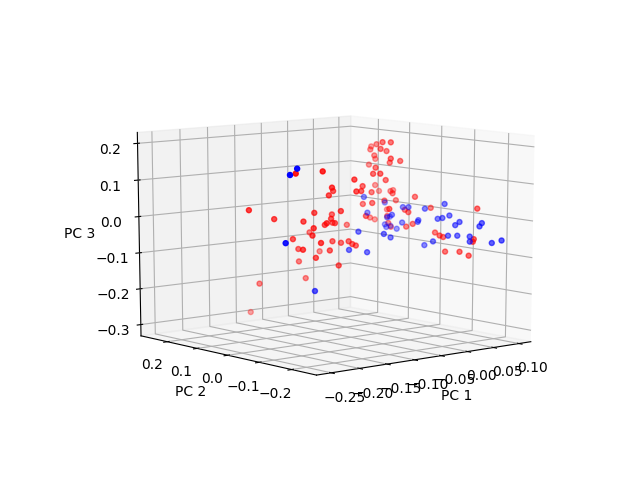

In [27]:
%matplotlib notebook

dims = 3

components, _ = perform_lle(all_cells, dims, number_of_neighbors=10, scale=True)
# components, _ = perform_mds(all_cells, dims, scale=True)

colors = ['red' if l == 0 else 'blue' for l in labels]
plot_kwargs = { 
    'c': colors,
    's': 13
}
plot_components(components, dims=dims, plot_kwargs=plot_kwargs)